In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd
from eofs.xarray import Eof

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

import pickle
import joblib

In [2]:
# return monthly average and regional longitude, latitude
# extract and group each month data
# after calculate the anomaly, remove the outliers
def month_data_u(anom, month):
    month_group = anom.groupby("time.month").groups # group into seasons, use groups to read each group
    month_index = month_group[month]
    month_anom = anom[month_index,:,:]
    #### THE THRESHOLD????
    #month_anom = xr.where((month_anom>5), 0, month_anom)
    return month_anom


# calculate normalized anomalies -- CESM
# climatology based on 1976 to 2005 
def nor_anom(dataset):
    ds_clm = dataset.sel(time=slice("1976", "2005")).load()

    rr_clm = ds_clm

    gb_clm = rr_clm.groupby("time.month") # gb_clm: grouped data into 12 month for climatology
    gb = dataset.groupby("time.month")
    prcp_anom = ((gb - gb_clm.mean(dim="time")).groupby("time.month"))/gb_clm.std(dim="time") # normalized
    # important to add two times groupby
    # gb.mean: only 12 month -- average daily prcp at each month
    # prcp_anom -- each month one anomaly
    return prcp_anom

In [3]:
def data_load_cesm_u(fn, start, end,region): # 'TP' 'NA' 'MD'
    ds_xr = xr.open_dataset(fn, chunks={"time": 10})
    ds_xr = ds_xr.sel(time=slice(start, end)).load()
    # convert 0-360 to -180-180
    #ds_xr = ds_xr.assign_coords(lon=(((ds_xr.lon + 180) % 360) - 180))
    # How to extract the desired region? -- by calculation
    reg_lon_xr = ds_xr['lon'] # from -40.375W to 75.375E
    reg_lat_xr = ds_xr['lat'] # from 25.375N to 75.375N
    temp_xr = ds_xr['U200']
    ## daily to monthly
    monthly_u = temp_xr.resample(time = '1M').mean()
    # lat: -20 to 90; lon: -180 to 180
    if region == 'NP': 
        # combine for merge two dataset with same coordinate
        xr1 = monthly_u[:,127:171,92:193] # (29N:70N; 115E:120W)
    if region == 'NA': 
        # combine for merge two dataset with same coordinate
        #xr1 = xr.concat([monthly_z[:,:,187:369,284:], monthly_z[:,:,187:369,:41]], dim="nlon")
        xr1=xr.concat([monthly_u[:,75:,216:],monthly_u[:,75:,:73]], dim="lon")
        # (-20-90N, 90w-40E)
    #xr1 = xr.concat([temp_xr[:,135:175,-10:], temp_xr[:,135:175,:45]], dim="lon")
    # time, lat, lon
    return xr1, reg_lat_xr, reg_lon_xr

In [4]:
import os
path = '/Data/gfi/share/ModData/CESM_LENS/U200'
filelist = os.listdir(path)

pathlist = []
for i in range(len(filelist)):
    temp = path + '/' + filelist[i]
    pathlist.append(temp)
    
fn1 = pathlist[0]
# take the right time
temp_xr = xr.open_dataset(fn1, chunks={"time": 19968})
### only ensemble 1 have 192001 ###
temp_xr = temp_xr.sel(time=slice('192001', '200512')).load() # be aware of the time here!!!

In [5]:
temp_xr.lat

<xarray.DataArray 'lat' (lat: 192)>
array([-90.      , -89.057592, -88.115183, -87.172775, -86.230366, -85.287958,
       -84.34555 , -83.403141, -82.460733, -81.518325, -80.575916, -79.633508,
       -78.691099, -77.748691, -76.806283, -75.863874, -74.921466, -73.979058,
       -73.036649, -72.094241, -71.151832, -70.209424, -69.267016, -68.324607,
       -67.382199, -66.439791, -65.497382, -64.554974, -63.612565, -62.670157,
       -61.727749, -60.78534 , -59.842932, -58.900524, -57.958115, -57.015707,
       -56.073298, -55.13089 , -54.188482, -53.246073, -52.303665, -51.361257,
       -50.418848, -49.47644 , -48.534031, -47.591623, -46.649215, -45.706806,
       -44.764398, -43.82199 , -42.879581, -41.937173, -40.994764, -40.052356,
       -39.109948, -38.167539, -37.225131, -36.282723, -35.340314, -34.397906,
       -33.455497, -32.513089, -31.570681, -30.628272, -29.685864, -28.743455,
       -27.801047, -26.858639, -25.91623 , -24.973822, -24.031414, -23.089005,
       -22.146597, -21.204188, -20.26178 , -19.319372, -18.376963, -17.434555,
       -16.492147, -15.549738, -14.60733 , -13.664921, -12.722513, -11.780105,
       -10.837696,  -9.895288,  -8.95288 ,  -8.010471,  -7.068063,  -6.125654,
        -5.183246,  -4.240838,  -3.298429,  -2.356021,  -1.413613,  -0.471204,
         0.471204,   1.413613,   2.356021,   3.298429,   4.240838,   5.183246,
         6.125654,   7.068063,   8.010471,   8.95288 ,   9.895288,  10.837696,
        11.780105,  12.722513,  13.664921,  14.60733 ,  15.549738,  16.492147,
        17.434555,  18.376963,  19.319372,  20.26178 ,  21.204188,  22.146597,
        23.089005,  24.031414,  24.973822,  25.91623 ,  26.858639,  27.801047,
        28.743455,  29.685864,  30.628272,  31.570681,  32.513089,  33.455497,
        34.397906,  35.340314,  36.282723,  37.225131,  38.167539,  39.109948,
        40.052356,  40.994764,  41.937173,  42.879581,  43.82199 ,  44.764398,
        45.706806,  46.649215,  47.591623,  48.534031,  49.47644 ,  50.418848,
        51.361257,  52.303665,  53.246073,  54.188482,  55.13089 ,  56.073298,
        57.015707,  57.958115,  58.900524,  59.842932,  60.78534 ,  61.727749,
        62.670157,  63.612565,  64.554974,  65.497382,  66.439791,  67.382199,
        68.324607,  69.267016,  70.209424,  71.151832,  72.094241,  73.036649,
        73.979058,  74.921466,  75.863874,  76.806283,  77.748691,  78.691099,
        79.633508,  80.575916,  81.518325,  82.460733,  83.403141,  84.34555 ,
        85.287958,  86.230366,  87.172775,  88.115183,  89.057592,  90.      ])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes:
    long_name:  latitude
    units:      degrees_north

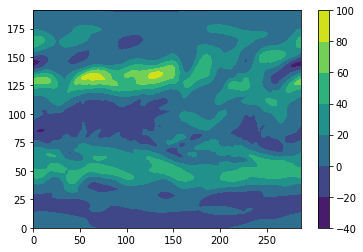

In [6]:
plt.contourf(temp_xr.U200[1])
plt.colorbar()

In [8]:
# preprocess SST -- all data together
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## change parameter for different region ##
region = 'NA'

fn1 = pathlist[0]
# take the right time

u_xr, reg_lat_xr, reg_lon_xr = data_load_cesm_u(fn1, '192001', '200512',region) # only monthly data has that problem

# calculate anomaly
u_anom = nor_anom(u_xr)

# detrend the time series at each grid point
u_danom = detrend_dim(u_anom, 'time', deg=1)

# extract and group each season data
#anom_ensemble = sst_anom
anom_original = u_danom

data = anom_original.values # remove dimension = 1
time = anom_original.time
lat = anom_original.lat
lon = anom_original.lon
anom_ensemble = xr.DataArray(data, 
                        coords=[time, lat,lon], 
                        dims=['time', 'lat', 'lon'])

In [14]:
anom_ensemble

<xarray.DataArray (time: 39216, lat: 117, lon: 288)>
array([[[-3.19952180e-01, -3.21400263e-01, -3.08981620e-01, ...,
         -2.24962959e-01, -2.53388043e-01, -2.93649169e-01],
        [-4.23929264e-01, -4.43600090e-01, -4.34096176e-01, ...,
         -3.40523120e-01, -3.43710564e-01, -3.75171294e-01],
        [-5.32106242e-01, -5.46576861e-01, -5.24671891e-01, ...,
         -5.01800787e-01, -4.79707064e-01, -4.90975028e-01],
        ...,
        [ 2.45822987e-01,  2.43480734e-01,  2.41077553e-01, ...,
          2.52472206e-01,  2.50319809e-01,  2.48103157e-01],
        [ 2.61883961e-01,  2.57947217e-01,  2.53961717e-01, ...,
          2.73441072e-01,  2.69626554e-01,  2.65775691e-01],
        [ 2.51569492e-01,  2.45836990e-01,  2.40093079e-01, ...,
          2.68717576e-01,  2.63008025e-01,  2.57292578e-01]],

       [[ 9.63027023e-03,  1.31703614e-01,  2.07972643e-01, ...,
         -3.95745873e-01, -3.14825445e-01, -1.60270836e-01],
        [-5.31394823e-02,  2.47013221e-02,  7.24468188e-02, ...,
         -4.11010509e-01, -3.21493313e-01, -1.78245116e-01],
        [-1.29043340e-01, -8.53559911e-02, -5.83107054e-02, ...,
         -3.79054548e-01, -2.84317439e-01, -1.91681229e-01],
...
        [ 1.02941971e+00,  1.02338888e+00,  1.01706567e+00, ...,
          1.04552416e+00,  1.04051270e+00,  1.03513607e+00],
        [ 1.22623276e+00,  1.22087307e+00,  1.21510130e+00, ...,
          1.23968033e+00,  1.23565274e+00,  1.23116438e+00],
        [ 1.40780755e+00,  1.40194538e+00,  1.39561570e+00, ...,
          1.42247019e+00,  1.41808217e+00,  1.41319054e+00]],

       [[ 1.09146795e+00,  1.01950293e+00,  9.19561629e-01, ...,
          1.17417467e+00,  1.17708243e+00,  1.13876265e+00],
        [ 1.13439672e+00,  1.06694394e+00,  9.98577470e-01, ...,
          1.31271047e+00,  1.25986132e+00,  1.19199724e+00],
        [ 1.12749710e+00,  1.07619872e+00,  1.06433081e+00, ...,
          1.35168737e+00,  1.26275795e+00,  1.18728318e+00],
        ...,
        [ 4.11471591e-01,  4.66899910e-01,  5.21177595e-01, ...,
          2.38380053e-01,  2.97198050e-01,  3.54900400e-01],
        [ 4.96189101e-01,  5.47215287e-01,  5.97054694e-01, ...,
          3.35962139e-01,  3.90560020e-01,  4.43969776e-01],
        [ 6.09892578e-01,  6.57376313e-01,  7.03608556e-01, ...,
          4.59776675e-01,  5.11104775e-01,  5.61140078e-01]]])
Coordinates:
  * time     (time) object 1920-01-31 00:00:00 ... 2005-12-31 00:00:00
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 ... 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [9]:
##### ensemble #####
for i in range(1,len(filelist)):

    fn1 = pathlist[i]
    u_xr, reg_lat_xr, reg_lon_xr = data_load_cesm_u(fn1, '192001', '200512', region)

    # total precipitation -- prect mm/day
    #prect_xr = precl_xr + precc_xr

    # calculate anomaly
    u_anom = nor_anom(u_xr)

    # detrend the time series at each grid point
    u_danom = detrend_dim(u_anom, 'time', deg=1)
    
    anom_gb_temp = u_danom
    
    #if np.array_equal(anom_original.lat, z_danom.lat) == False: # check if two array is exactly the same
    data = u_danom.values # remove dimension = 1
    time = anom_original.time
    lat = anom_original.lat
    lon = anom_original.lon
    anom_gb_temp = xr.DataArray(data, 
                            coords=[time, lat,lon], 
                            dims=['time', 'lat', 'lon'])

    anom_ensemble = xr.concat([anom_ensemble,anom_gb_temp], dim='time')

In [10]:
### save and load as netcdf ###
anom_ensemble.to_netcdf(r'/shared/home/yzh086/code/task1/result/ensemble/u200_na.nc')
### save and load as netcdf ###
#ensemble = xr.open_dataset(r'/shared/home/yzh086/code/task1/result/ensemble/u200_np.nc', chunks={"time": 19968})

In [20]:
ensemble = xr.open_dataset(r'/shared/home/yzh086/code/task1/result/ensemble/u200_np.nc')

In [21]:
ensemble=ensemble.__xarray_dataarray_variable__

In [22]:
region = 'np'

In [23]:
### For winter ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([12,1,2])] # select data of 12,1,2 month
# take the rolling series from 1921 to 2005
sst_rolling = sst_all[2:-1]
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 2]
# mean at 1920
sst1 = sst_all[:2].mean(dim='time')
# reshape time to (1,)
time = sst_all[1].time.values.reshape(1,)
lat = sst_all[1].lat
lon = sst_all[1].lon
#tlat = sst_all[1].TLAT
#tlong = sst_all[1].TLONG
sst1 = xr.DataArray(sst1.values.reshape(1,sst_all.shape[1],sst_all.shape[2]),coords=[time,lat,lon],dims=('time', 'lat', 'lon'))
#sst1 = xr.DataArray(sst1.values.reshape(1,sst_all.shape[1],sst_all.shape[2]),coords={'time':time, 
 #                                     'TLAT':(("nlat", "nlon"), np.array(tlat)),
  #                                    'TLONG':(("nlat", "nlon"), np.array(tlong))}, 
   #                                     dims=['time', 'nlat', 'nlon'])

# concat two array
sst_series = xr.concat([sst1, sst2], dim="time")

In [13]:
sst_series

<xarray.DataArray (time: 3440, lat: 117, lon: 145)>
array([[[-0.09070795, -0.0983164 , -0.09827172, ...,  0.75045255,
          0.6628925 ,  0.56130033],
        [-0.15633057, -0.15209635, -0.15230518, ...,  0.67780443,
          0.6089127 ,  0.53418644],
        [-0.19954605, -0.18428022, -0.18243958, ...,  0.61038542,
          0.57236712,  0.53932983],
        ...,
        [ 0.04332394,  0.05573813,  0.06804167, ..., -0.22673822,
         -0.2326241 , -0.23862043],
        [ 0.07765173,  0.0899824 ,  0.10225937, ..., -0.14653364,
         -0.15553178, -0.1646077 ],
        [ 0.11445857,  0.12559628,  0.13675946, ..., -0.09230079,
         -0.10335678, -0.11445857]],

       [[-0.35272309, -0.27440011, -0.19996943, ..., -0.58548777,
         -0.60164071, -0.61294032],
        [-0.38552054, -0.31467758, -0.2471674 , ..., -0.62647117,
         -0.63373599, -0.63692677],
        [-0.42478938, -0.36433459, -0.30320706, ..., -0.64613348,
         -0.6456979 , -0.64604868],
...
        [ 0.03113354,  0.00432265, -0.02264104, ..., -0.053222  ,
         -0.03018496, -0.00681649],
        [ 0.00969902, -0.01662249, -0.04321159, ..., -0.08293966,
         -0.05852008, -0.03374169],
        [ 0.02876477,  0.00291099, -0.02328912, ..., -0.0794287 ,
         -0.05427066, -0.02876477]],

       [[-0.10016445, -0.07119569, -0.0837385 , ..., -0.84312341,
         -0.79234135, -0.71547687],
        [-0.1680974 , -0.15499418, -0.17471033, ..., -0.77987667,
         -0.74584357, -0.6816493 ],
        [-0.24998909, -0.24411939, -0.25823319, ..., -0.7402549 ,
         -0.73018637, -0.68280259],
        ...,
        [-0.38545486, -0.39267327, -0.39943749, ...,  0.25707222,
          0.25654059,  0.25611576],
        [-0.36314931, -0.36896255, -0.37450555, ...,  0.30286639,
          0.30547911,  0.30808299],
        [-0.32133135, -0.32597935, -0.33051125, ...,  0.31171181,
          0.31657362,  0.32133135]]])
Coordinates:
  * time     (time) object 1920-02-28 00:00:00 ... 2005-02-28 00:00:00
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 ... 88.12 89.06 90.0
  * lon      (lon) float64 270.0 271.2 272.5 273.8 ... 86.25 87.5 88.75 90.0

In [26]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# pre-process before EOF 
# 1.reshape in 2D (time, space)
#lat = ensemble.nlat.values
#lon = ensemble.nlon.values
#sst = ensemble.values
#X = np.reshape(sst, (sst.shape[0], len(lat) * len(lon)), order='F') # 2D array prepared for EOF

# weighted by latitude
meantlat = sst_series.lat
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(44, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()


eof_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_eof_djf_%s.nc' % region)
pc_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_pc_djf_%s.nc' % region)
varfrac_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_var_djf_%s.nc' % region)
lambdas_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_lam_djf_%s.nc' % region)

In [27]:
### For MAM ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([3,4,5])] # select data of each season
# take the rolling series from 1921 to 2005
sst_rolling = sst_all
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 5]
# mean at 1920
#sst1 = sst_all[:2].mean(dim='time')
# reshape time to (1,)
#time = sst_all[1].time.values.reshape(1,)
#lat = sst_all[1].lat
#lon = sst_all[1].lon
#tlat = sst_all[1].TLAT
#tlong = sst_all[1].TLONG
#sst1 = xr.DataArray(sst1.values.reshape(1,64,105),coords=[time,lat,lon],dims=('time', 'lat', 'lon'))
#sst1 = xr.DataArray(sst1.values.reshape(1,sst_all.shape[1],sst_all.shape[2]),coords={'time':time, 
                                      #'TLAT':(("nlat", "nlon"), np.array(tlat)),
                                      #'TLONG':(("nlat", "nlon"), np.array(tlong))}, 
                                      #  dims=['time', 'nlat', 'nlon'])

# concat two array
sst_series = sst2

### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# pre-process before EOF 
# 1.reshape in 2D (time, space)
#lat = ensemble.nlat.values
#lon = ensemble.nlon.values
#sst = ensemble.values
#X = np.reshape(sst, (sst.shape[0], len(lat) * len(lon)), order='F') # 2D array prepared for EOF

# weighted by latitude
meantlat = meantlat = sst_series.lat
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(44, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_eof_mam_%s.nc' % region)
pc_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_pc_mam_%s.nc' % region)
varfrac_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_var_mam_%s.nc' % region)
lambdas_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_lam_mam_%s.nc' % region)

In [28]:
### For JJA ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([6,7,8])] # select data of each season
# take the rolling series from 1921 to 2005
sst_rolling = sst_all
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 8]
# mean at 1920
#sst1 = sst_all[:2].mean(dim='time')
# reshape time to (1,)
#time = sst_all[1].time.values.reshape(1,)
#lat = sst_all[1].lat
#lon = sst_all[1].lon
#tlat = sst_all[1].TLAT
#tlong = sst_all[1].TLONG
#sst1 = xr.DataArray(sst1.values.reshape(1,64,105),coords=[time,lat,lon],dims=('time', 'lat', 'lon'))
#sst1 = xr.DataArray(sst1.values.reshape(1,sst_all.shape[1],sst_all.shape[2]),coords={'time':time, 
                                      #'TLAT':(("nlat", "nlon"), np.array(tlat)),
                                      #'TLONG':(("nlat", "nlon"), np.array(tlong))}, 
                                      #  dims=['time', 'nlat', 'nlon'])

# concat two array
sst_series = sst2

### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# pre-process before EOF 
# 1.reshape in 2D (time, space)
#lat = ensemble.nlat.values
#lon = ensemble.nlon.values
#sst = ensemble.values
#X = np.reshape(sst, (sst.shape[0], len(lat) * len(lon)), order='F') # 2D array prepared for EOF

# weighted by latitude
meantlat = meantlat = sst_series.lat
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(44, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_eof_jja_%s.nc' % region)
pc_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_pc_jja_%s.nc' % region)
varfrac_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_var_jja_%s.nc' % region)
lambdas_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_lam_jja_%s.nc' % region)

In [29]:
### For SON ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([9,10,11])] # select data of each season
# take the rolling series from 1921 to 2005
sst_rolling = sst_all
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 11]
# mean at 1920
#sst1 = sst_all[:2].mean(dim='time')
# reshape time to (1,)
#time = sst_all[1].time.values.reshape(1,)
#lat = sst_all[1].lat
#lon = sst_all[1].lon
#tlat = sst_all[1].TLAT
#tlong = sst_all[1].TLONG
#sst1 = xr.DataArray(sst1.values.reshape(1,64,105),coords=[time,lat,lon],dims=('time', 'lat', 'lon'))
#sst1 = xr.DataArray(sst1.values.reshape(1,sst_all.shape[1],sst_all.shape[2]),coords={'time':time, 
                                      #'TLAT':(("nlat", "nlon"), np.array(tlat)),
                                      #'TLONG':(("nlat", "nlon"), np.array(tlong))}, 
                                      #  dims=['time', 'nlat', 'nlon'])

# concat two array
sst_series = sst2

### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# pre-process before EOF 
# 1.reshape in 2D (time, space)
#lat = ensemble.nlat.values
#lon = ensemble.nlon.values
#sst = ensemble.values
#X = np.reshape(sst, (sst.shape[0], len(lat) * len(lon)), order='F') # 2D array prepared for EOF

# weighted by latitude
meantlat = meantlat = sst_series.lat
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(44, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_eof_son_%s.nc' % region)
pc_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_pc_son_%s.nc' % region)
varfrac_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_var_son_%s.nc' % region)
lambdas_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_lam_son_%s.nc' % region)

In [18]:
ensemble.time

<xarray.DataArray 'time' (time: 41280)>
array([cftime.DatetimeNoLeap(1920, 1, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1920, 2, 28, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1920, 3, 31, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2005, 10, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 11, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1920-01-31 00:00:00 ... 2005-12-31 00:00:00

In [19]:
time = ensemble.time
lat = ensemble.lat
lon = ensemble.lon

ensemble_new = xr.DataArray(ensemble.values, 
                            coords=[time, lat,lon], 
                            dims=['time', 'lat', 'lon'])

In [20]:
ensemble_new

<xarray.DataArray (time: 41280, lat: 117, lon: 145)>
array([[[-0.07323182, -0.12617502, -0.16708613, ...,  0.68324246,
          0.61218604,  0.54220711],
        [-0.18159719, -0.23650312, -0.28129881, ...,  0.61925261,
          0.57187684,  0.51932649],
        [-0.26543046, -0.32060526, -0.36801116, ...,  0.58708378,
          0.55578841,  0.50771514],
        ...,
        [ 0.17540469,  0.17795264,  0.18045587, ..., -0.36696352,
         -0.38479124, -0.40257182],
        [ 0.28052391,  0.28746653,  0.29425065, ..., -0.34605192,
         -0.36008587, -0.37401476],
        [ 0.31682035,  0.32647316,  0.33594892, ..., -0.29707927,
         -0.30701467, -0.31682035]],

       [[-0.10818408, -0.07045777, -0.02945732, ...,  0.81766264,
          0.71359896,  0.58039354],
        [-0.13106396, -0.06768959, -0.02331154, ...,  0.73635626,
          0.64594855,  0.54904638],
        [-0.13366165, -0.04795519,  0.003132  , ...,  0.63368705,
          0.58894583,  0.57094452],
...
        [-0.27379346, -0.31188438, -0.35042145, ...,  0.77527786,
          0.83745922,  0.89966071],
        [-0.36373183, -0.40955046, -0.45577119, ...,  0.58038876,
          0.63731549,  0.69448492],
        [-0.53540131, -0.58763248, -0.64010876, ...,  0.43186056,
          0.483463  ,  0.53540131]],

       [[-0.69345148, -0.7417098 , -0.79172093, ...,  0.73631902,
          0.68497948,  0.64442699],
        [-0.67250542, -0.67713737, -0.70016025, ...,  0.71110847,
          0.67129437,  0.6510375 ],
        [-0.63081567, -0.60796715, -0.60144342, ...,  0.72651548,
          0.71232597,  0.71920002],
        ...,
        [-0.84748764, -0.83731312, -0.82632988, ...,  0.3563217 ,
          0.33385176,  0.31130942],
        [-0.68652419, -0.67154163, -0.65598965, ...,  0.46653988,
          0.44572304,  0.42460035],
        [-0.53937182, -0.5195769 , -0.49933233, ...,  0.57762971,
          0.5587209 ,  0.53937182]]])
Coordinates:
  * time     (time) object 1920-01-31 00:00:00 ... 2005-12-31 00:00:00
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 ... 88.12 89.06 90.0
  * lon      (lon) float64 270.0 271.2 272.5 273.8 ... 86.25 87.5 88.75 90.0

In [4]:
ensemble = xr.open_dataset(r'/shared/home/yzh086/code/task1/result/ensemble/u200_na.nc', chunks={"time": 19968})

In [7]:
##### save the data -- no need to run the previous again #####

df = open(r'/shared/home/yzh086/code/task1/result/ensemble/u200_%s.txt' % region,'wb') # works well protocol
pickle.dump(anom_ensemble, df, protocol=4)
df.close()

In [14]:
##### open the file for next use #####
df2 = open(r'/shared/home/yzh086/code/task1/result/ensemble/u200_%s.txt' % region,'rb')
ensemble = pickle.load(df2)
df2.close()

In [9]:
##### open the file for next use #####
df2 = open(r'/shared/home/yzh086/code/task1/result/ensemble/u200.txt' ,'rb')
ensemble = pickle.load(df2)
df2.close()

In [14]:
region = 'NA'

In [21]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
#meantlat = np.mean(ensemble.lat.values, axis = 1)
wgts   = np.cos(np.deg2rad(ensemble_new.lat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(117, 1) ## depends on the shape of region

solver = Eof(ensemble_new, weights=wgts)

In [22]:
eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

In [23]:
eof_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_eof_%s.nc' % region)
pc_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_pc_%s.nc' % region)
varfrac_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_var_%s.nc' % region)
lambdas_en.to_netcdf(r'/shared/home/yzh086/code/task1/result/eof_u200/u200_lam_%s.nc' % region)

In [24]:
eof_en

<xarray.DataArray 'eofs' (mode: 10, lat: 117, lon: 145)>
array([[[ 3.24060265e-03,  3.30818041e-03,  3.38968380e-03, ...,
          7.53915102e-03,  7.36941226e-03,  7.18994675e-03],
        [ 3.64951409e-03,  3.78705837e-03,  3.93708192e-03, ...,
          7.82370194e-03,  7.61538044e-03,  7.40086732e-03],
        [ 4.07803406e-03,  4.28628351e-03,  4.50439976e-03, ...,
          8.05917852e-03,  7.81727681e-03,  7.57219928e-03],
        ...,
        [ 3.91786310e-07, -6.34420023e-07, -1.66019220e-06, ...,
         -2.01610348e-05, -1.91681378e-05, -1.81502952e-05],
        [ 2.35466805e-06,  1.82160517e-06,  1.28390899e-06, ...,
         -7.65905181e-06, -7.13909365e-06, -6.61046701e-06],
        [ 1.65907607e-20,  1.45635319e-20,  1.25165087e-20, ...,
         -2.05620515e-20, -1.85886911e-20, -1.65907607e-20]],

       [[ 2.45109948e-03,  2.62408984e-03,  2.76572964e-03, ...,
          1.33788766e-02,  1.31070606e-02,  1.27937364e-02],
        [ 1.46966757e-03,  1.63401406e-03,  1.76792511e-03, ...,
          1.40556314e-02,  1.37470880e-02,  1.33996105e-02],
        [ 4.17951654e-04,  5.73928431e-04,  7.00681601e-04, ...,
          1.45413791e-02,  1.42093716e-02,  1.38379604e-02],
...
        [-2.05126779e-04, -2.00490649e-04, -1.95691752e-04, ...,
          2.10152111e-04,  2.05165268e-04,  2.00123635e-04],
        [-1.03016342e-04, -1.00626894e-04, -9.81655291e-05, ...,
          1.09621402e-04,  1.07229752e-04,  1.04788618e-04],
        [-3.88723272e-19, -3.79548807e-19, -3.70141033e-19, ...,
          4.06376792e-19,  3.97664262e-19,  3.88723272e-19]],

       [[-6.09221190e-03, -6.57175337e-03, -7.07287630e-03, ...,
         -8.47963823e-03, -8.80904214e-03, -9.12291932e-03],
        [-6.09367313e-03, -6.61808363e-03, -7.16647199e-03, ...,
         -8.88427335e-03, -9.20211410e-03, -9.50758701e-03],
        [-5.97011541e-03, -6.52508179e-03, -7.10883393e-03, ...,
         -9.22267394e-03, -9.53600357e-03, -9.83715432e-03],
        ...,
        [ 3.13682564e-04,  3.08325896e-04,  3.02813843e-04, ...,
         -3.11696034e-04, -3.03249067e-04, -2.94617581e-04],
        [ 1.57970068e-04,  1.54780256e-04,  1.51508491e-04, ...,
         -1.62504768e-04, -1.58738496e-04, -1.54883868e-04],
        [ 5.86233105e-19,  5.72855039e-19,  5.59140761e-19, ...,
         -6.12021221e-19, -5.99275068e-19, -5.86233105e-19]]])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 ... 88.12 89.06 90.0
  * lon      (lon) float64 270.0 271.2 272.5 273.8 ... 86.25 87.5 88.75 90.0
Attributes:
    long_name:  empirical_orthogonal_functions

In [ ]:
##### save data #####
import joblib
joblib.dump(eof_en, r'/shared/home/yzh086/code/task1/result/eof_u200/u_eof_%s.pkl' % region
            ,compress=9)
joblib.dump(pc_en, r'/shared/home/yzh086/code/task1/result/eof_u200/u_pc_%s.pkl' % region
            ,compress=9)
joblib.dump(varfrac_en, r'/shared/home/yzh086/code/task1/result/eof_u200/u_varfrac_%s.pkl' % region
            ,compress=9)
joblib.dump(lambdas_en, r'/shared/home/yzh086/code/task1/result/eof_u200/u_lambdas_%s.pkl' % region
            ,compress=9)

In [7]:
##### open data #####
import joblib

eof_en = joblib.load(r'/shared/home/yzh086/code/task1/result/eof_u200/u_eof1.pkl' )
pc_en = joblib.load(r'/shared/home/yzh086/code/task1/result/eof_u200/u_pc1.pkl')
varfrac_en = joblib.load(r'/shared/home/yzh086/code/task1/result/eof_u200/u_varfrac1.pkl')
lambdas_en = joblib.load(r'/shared/home/yzh086/code/task1/result/eof_u200/u_lambdas1.pkl')

In [8]:
pc_en

<xarray.DataArray 'pcs' (time: 20640, mode: 10)>
array([[ 43.07727555,   1.93920737, -40.80755113, ...,   1.06664432,
        -22.51028252,   0.20467612],
       [ 48.90297331,  -6.47370488, -23.96670749, ...,  15.05470215,
         18.6583955 ,  33.68202347],
       [  8.41908256, -38.40761741, -26.68150618, ..., -20.63939407,
         13.13663305,  -3.01555525],
       ...,
       [ 47.99038995,  30.4163248 ,   5.43250119, ...,  -6.81730941,
         -8.31949584,  -7.68955666],
       [ 72.605861  ,  39.96367288,  -1.46196896, ...,   7.93737653,
         40.06415464,  19.87641453],
       [ 86.95139983,  19.33960623, -21.99208164, ..., -12.94282527,
         14.7249514 ,  -9.10552675]])
Coordinates:
  * time     (time) object 1920-01-31 00:00:00 ... 2005-12-31 00:00:00
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9

In [7]:
eof_en

<xarray.DataArray 'eofs' (mode: 10, lat: 117, lon: 288)>
array([[[-4.42262461e-03, -4.58235072e-03, -4.73867420e-03, ...,
         -3.90034549e-03, -4.07983893e-03, -4.25539549e-03],
        [-5.54570971e-03, -5.69133214e-03, -5.83578633e-03, ...,
         -5.05441104e-03, -5.22428406e-03, -5.38959063e-03],
        [-6.54053929e-03, -6.67350099e-03, -6.80419765e-03, ...,
         -6.08808838e-03, -6.24471293e-03, -6.39716879e-03],
        ...,
        [ 4.44787903e-05,  4.45937257e-05,  4.46942229e-05, ...,
          4.40376438e-05,  4.42008084e-05,  4.43483704e-05],
        [ 2.47620142e-05,  2.47692004e-05,  2.47652067e-05, ...,
          2.46653477e-05,  2.47102807e-05,  2.47420621e-05],
        [ 9.83314106e-20,  9.82367079e-20,  9.80861043e-20, ...,
          9.82715408e-20,  9.83510395e-20,  9.83706548e-20]],

       [[-4.56249959e-03, -4.34839462e-03, -4.12440368e-03, ...,
         -5.08615175e-03, -4.93970287e-03, -4.76247906e-03],
        [-5.50705785e-03, -5.30085737e-03, -5.07875792e-03, ...,
         -6.00390129e-03, -5.86350294e-03, -5.69590496e-03],
        [-6.36737217e-03, -6.17153074e-03, -5.95581537e-03, ...,
         -6.81529090e-03, -6.69157169e-03, -6.54127235e-03],
...
        [-5.90647666e-05, -6.52400004e-05, -7.12644979e-05, ...,
         -3.96060719e-05, -4.62443431e-05, -5.27290545e-05],
        [-2.20030427e-05, -2.50314065e-05, -2.79962589e-05, ...,
         -1.25349135e-05, -1.57545031e-05, -1.89085639e-05],
        [-6.38677643e-20, -7.48929355e-20, -8.57045077e-20, ...,
         -2.96468269e-20, -4.12373512e-20, -5.26513444e-20]],

       [[-1.52810321e-03, -1.48068080e-03, -1.44821737e-03, ...,
         -1.70494874e-03, -1.65335231e-03, -1.59100372e-03],
        [-1.37192441e-03, -1.34962648e-03, -1.33127258e-03, ...,
         -1.47967717e-03, -1.44663754e-03, -1.40614373e-03],
        [-1.22886634e-03, -1.22571273e-03, -1.21705821e-03, ...,
         -1.23909511e-03, -1.24076539e-03, -1.23413614e-03],
        ...,
        [ 1.33988781e-04,  1.33576540e-04,  1.33076027e-04, ...,
          1.34589570e-04,  1.34504137e-04,  1.34296116e-04],
        [ 5.99640390e-05,  6.02545272e-05,  6.05048493e-05, ...,
          5.88248968e-05,  5.92512474e-05,  5.96292802e-05],
        [ 2.06620271e-19,  2.08984318e-19,  2.11212970e-19, ...,
          1.98667578e-19,  2.01460398e-19,  2.04119812e-19]]])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 ... 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    long_name:  empirical_orthogonal_functions

In [27]:
### re-apply for new coordinate since it is not equally placed ###
### this should be changed by different region ###
new_lat = np.linspace(-19.3,90,117) # -20 to 20
new_long = np.linspace(-180,180,288) # 110 E to 75 W

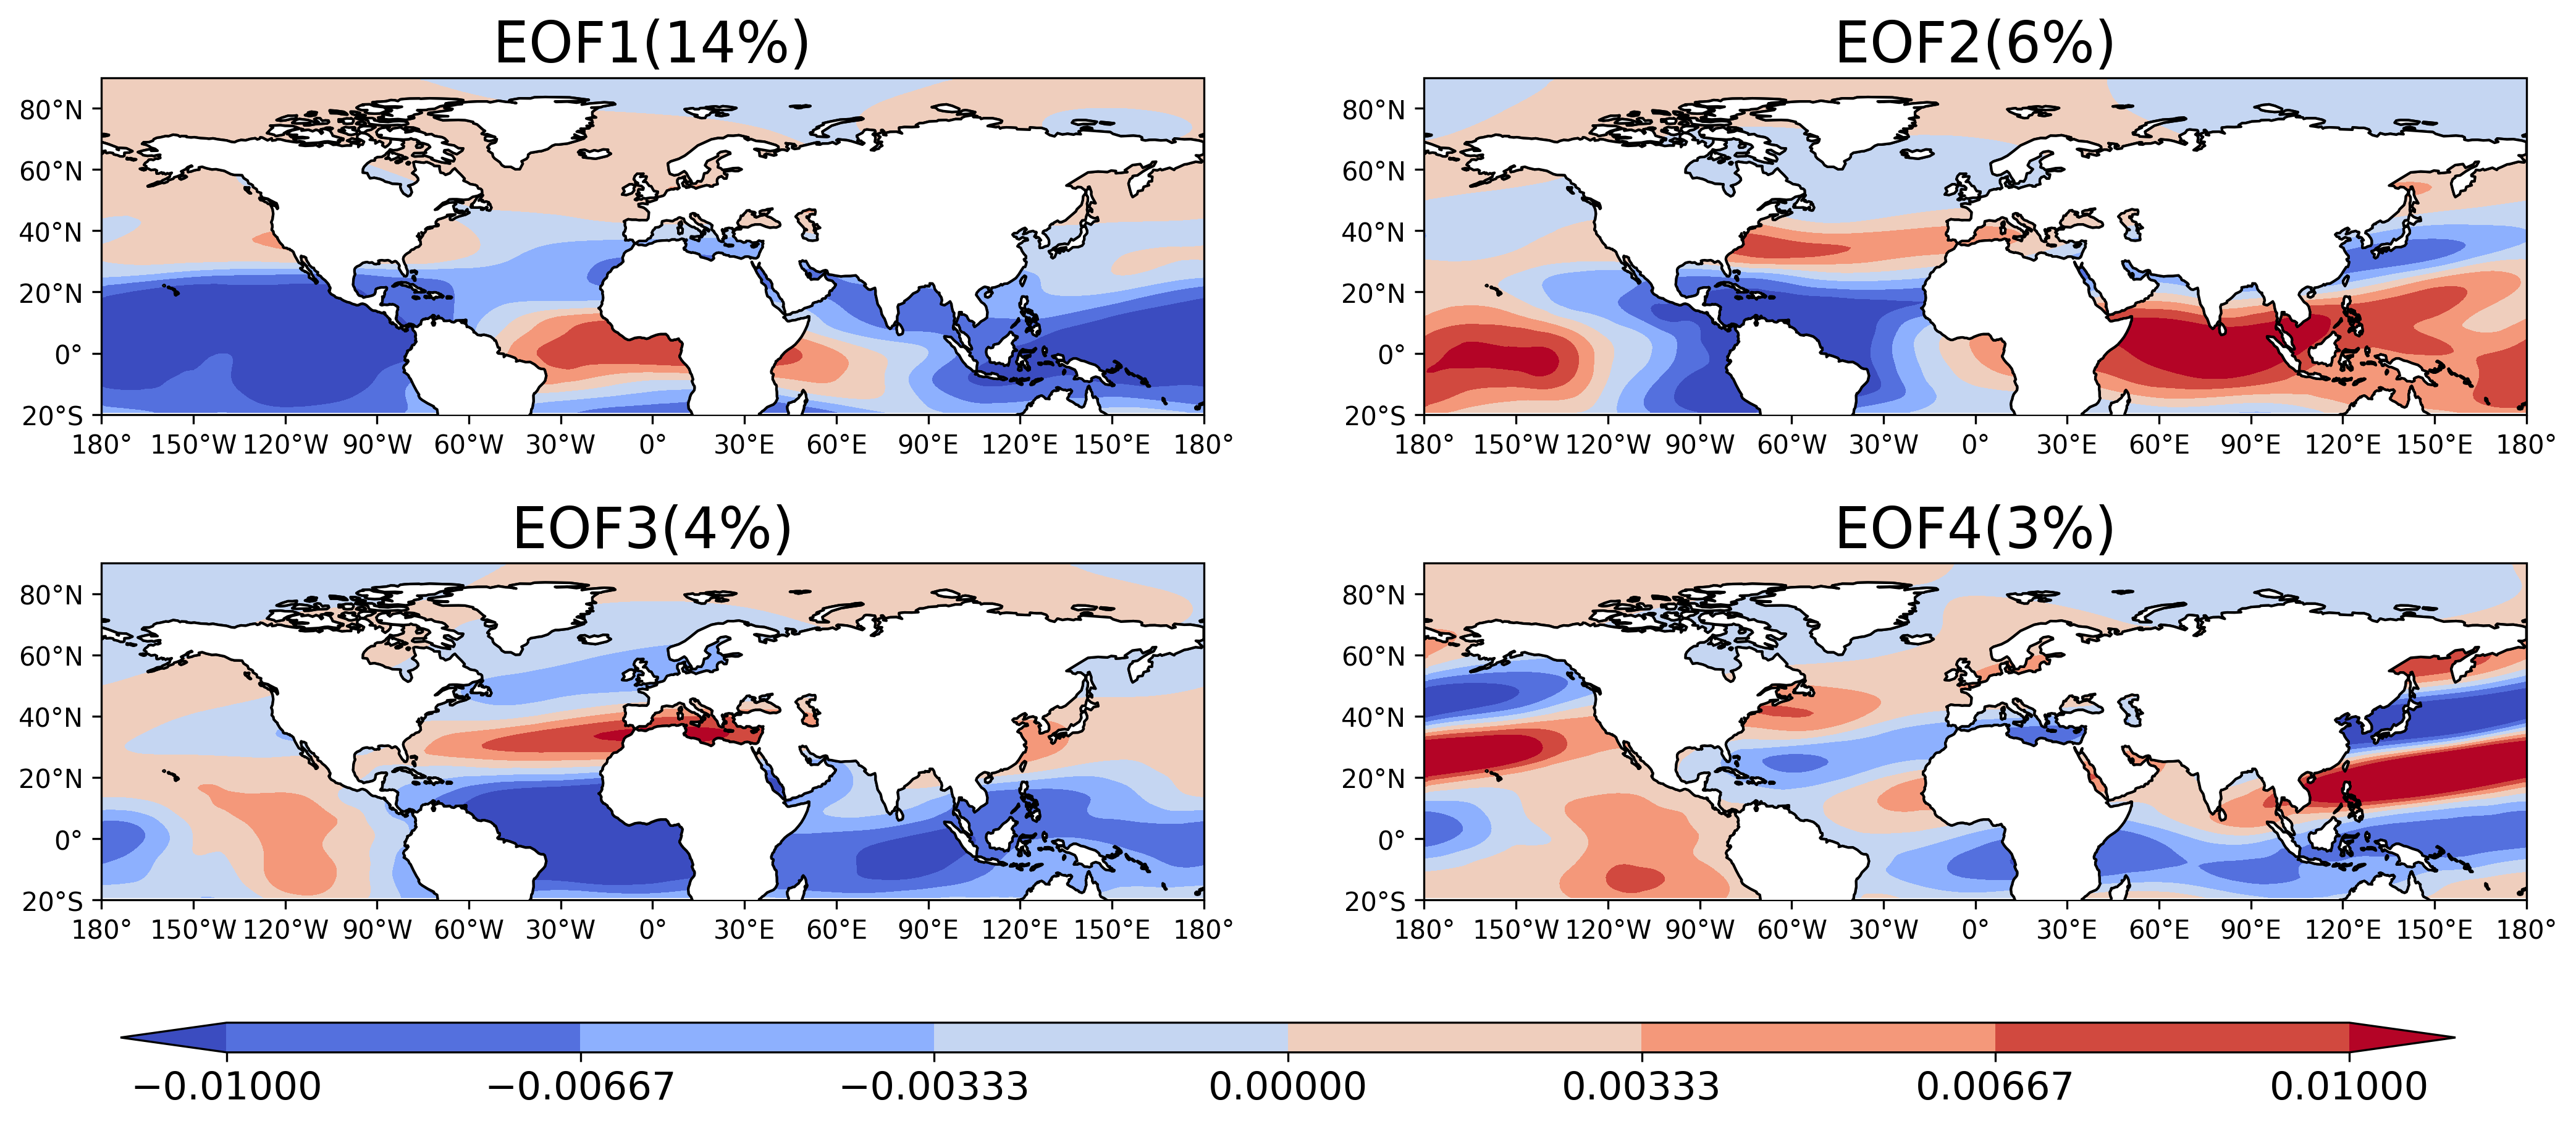

In [41]:
##### finally plot #####

#fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),dpi =300)
# if on the west sphere, change the central longitude

fig, axs = plt.subplots(2,2, figsize=(14,8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)),dpi =300)

fig = plt.gcf()

#title1 = '%s_cluster' % (season)

for ax, i in zip(axs.ravel(), range(4)):

    title2 = 'EOF%s(%s%%)' % (i+1, int(varfrac_en[i]*100))
    # tim
    data = eof_en[i]
    # Add cyclic point to data
    #data=mean_anom_djf_cluster1
    data, lons = add_cyclic_point(data, coord=new_long)
    lat = new_lat
    # Make a filled contour plot
    # Add coastlines
    ax.coastlines()

    # mask the LAND part with white color
    ax.add_feature(cart.feature.LAND, facecolor = 'white', zorder=200, edgecolor='k')

    cs=ax.contourf(lons, new_lat, data,
                transform = ccrs.PlateCarree(),cmap='coolwarm',levels = np.linspace(-0.01,0.01,7),
                   extend='both') # (lat, lon)

    # Define the xticks for longitude

    ax.set_xticks(np.arange(-180,210,30), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    #plt.title(title2, fontsize = 18)
    ax.set_title(title2, fontsize = 22)

    ax.set_yticks(np.arange(-20,100,20), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()
fig.subplots_adjust(bottom = 0.1, top = 0.7, hspace =0.2, wspace=.2)    

# Add colorbar
bar_cax = plt.axes([0.05, 0.02, 0.9,0.02]) # left&right, bottom, size, size
#plt.colorbar(cax=cax)
#cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar.ax.tick_params(labelsize = 15)
    
    
fig.savefig(r'/shared/home/yzh086/Task1/result/u200/eof_u200_1.png')

In [31]:
np.arange(-180,210,30)

array([-180, -150, -120,  -90,  -60,  -30,    0,   30,   60,   90,  120,
        150,  180])

/Data/gfi/users/local/share/virtualenv/dynpie3-2021a/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


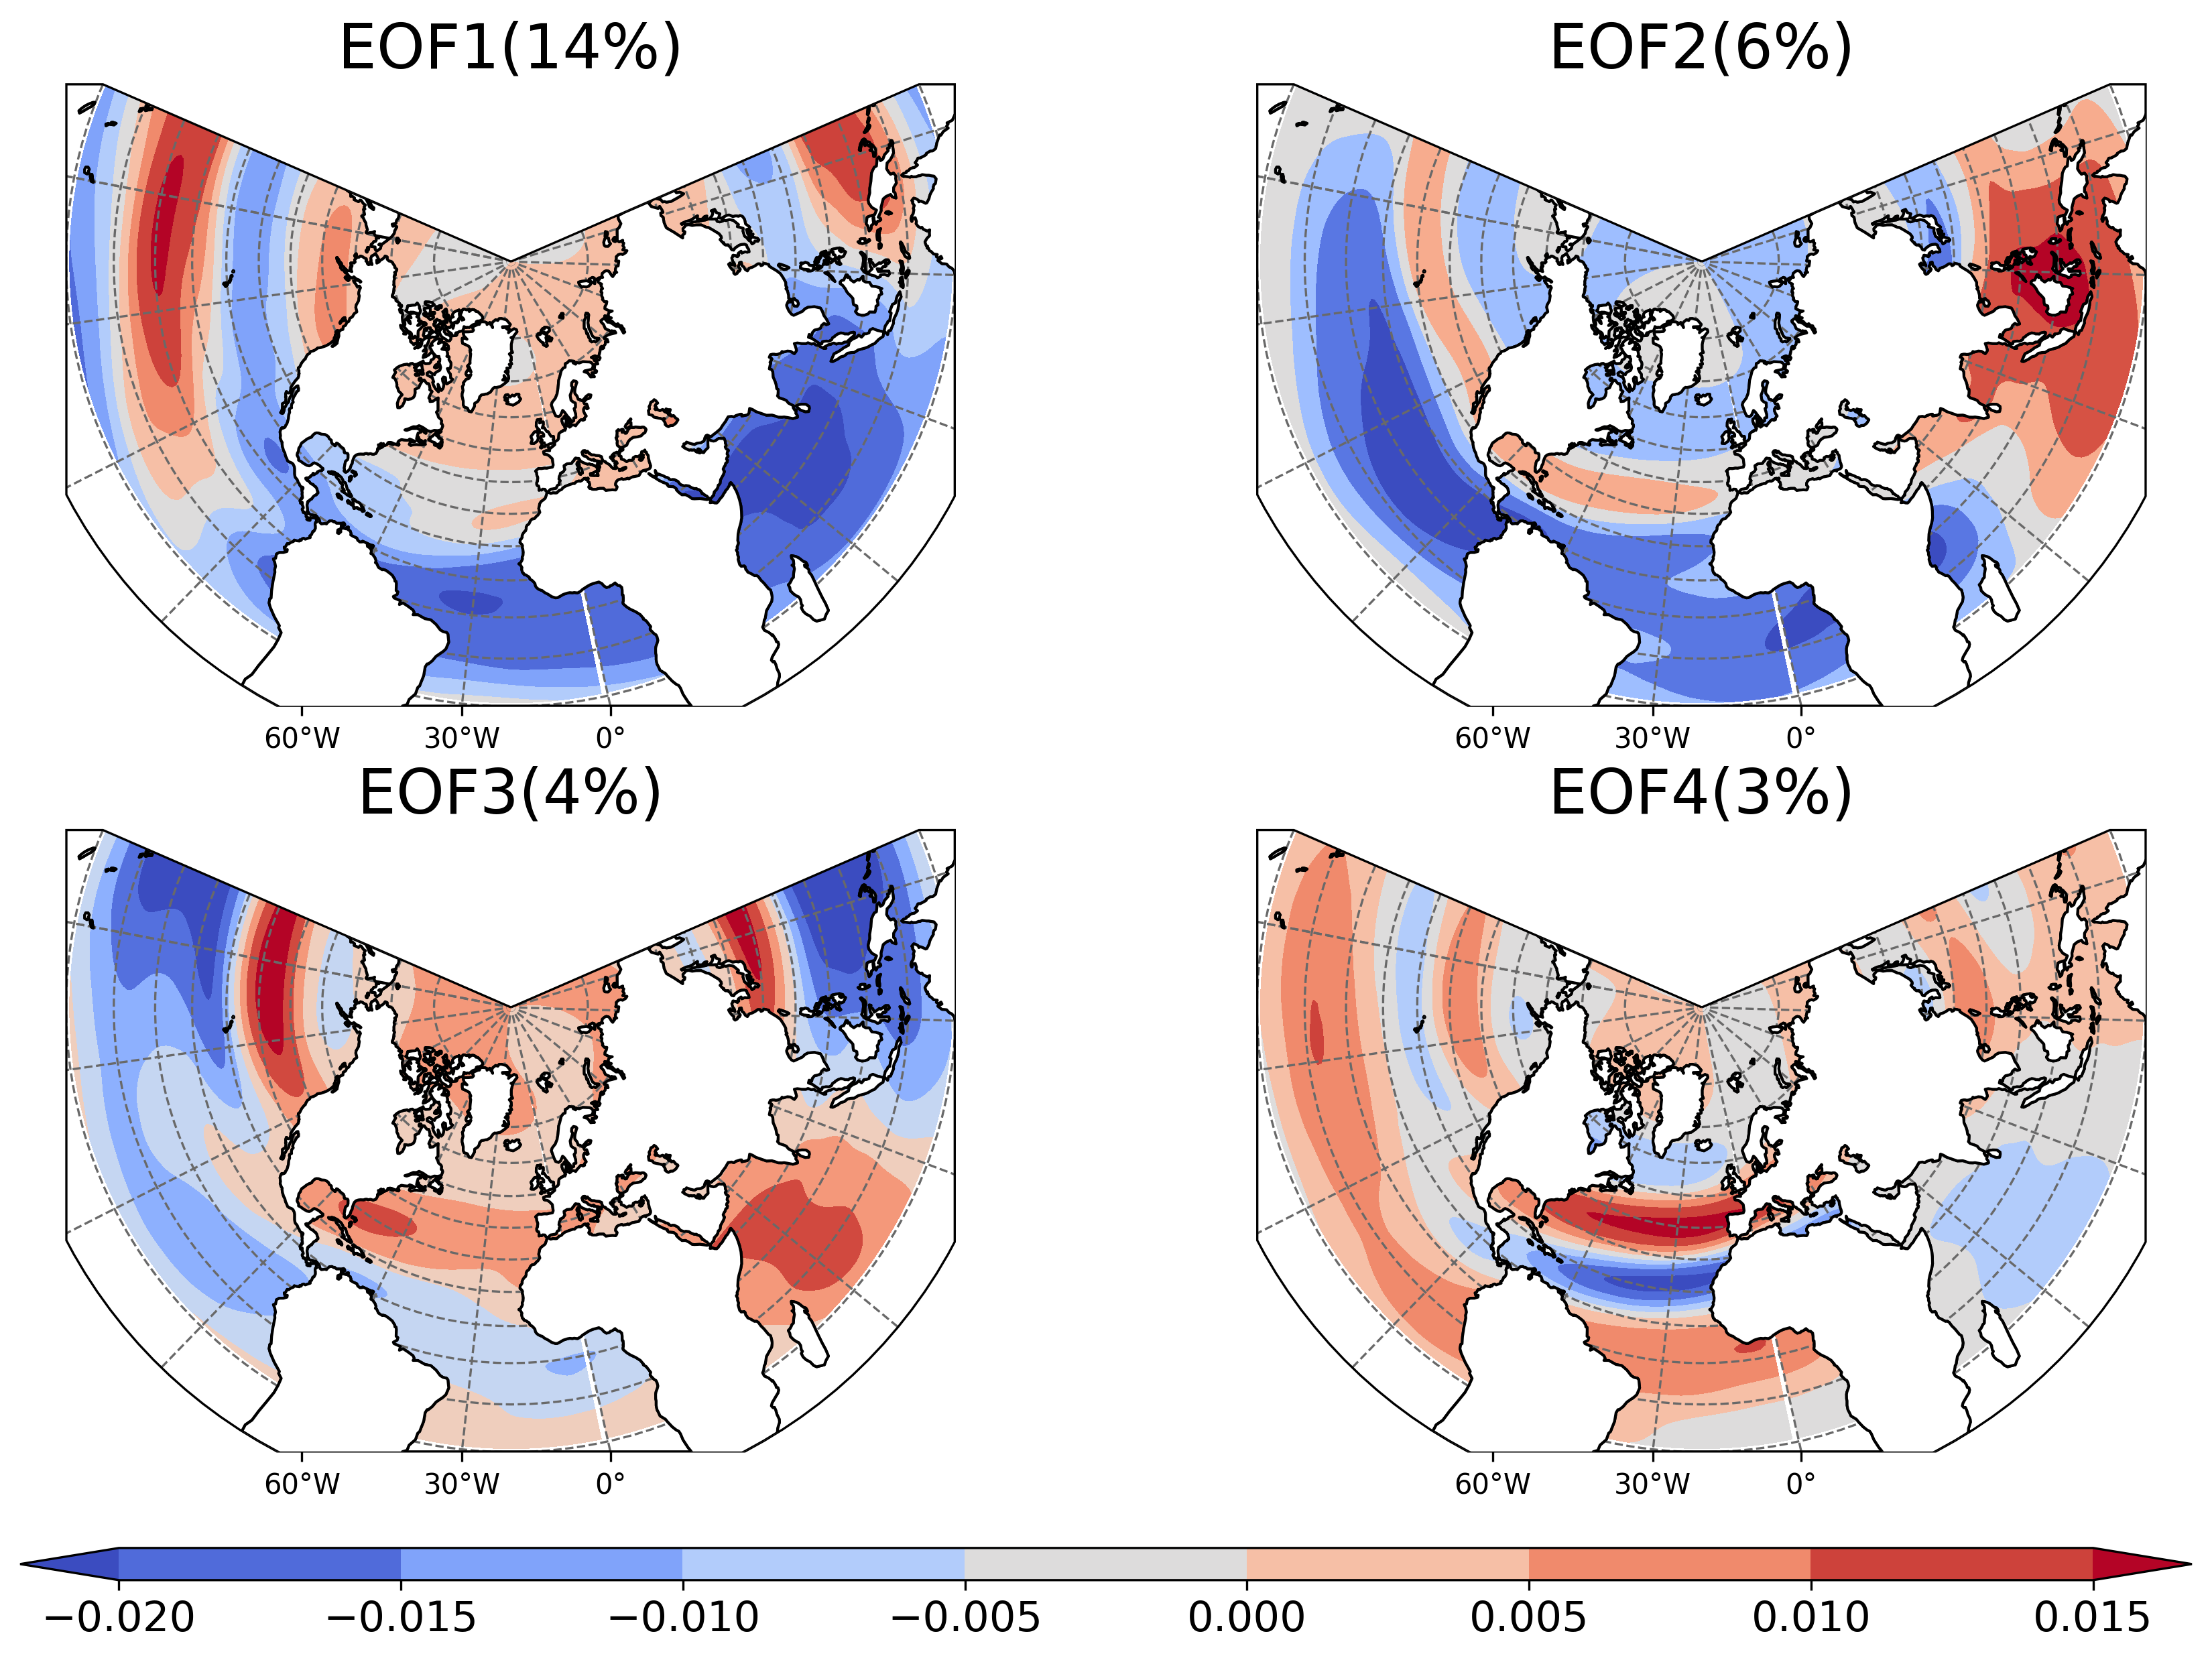

In [26]:
##### finally plot #####

#fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),dpi =300)
# if on the west sphere, change the central longitude
proj = ccrs.LambertConformal(central_longitude=-20, central_latitude=60)
fig, axs = plt.subplots(2,2, figsize=(12,8), subplot_kw=dict(projection=proj),dpi =300)

fig = plt.gcf()

#title1 = '%s_cluster' % (season)

for ax, i in zip(axs.ravel(), range(4)):

    title2 = 'EOF%s(%s%%)' % (i+1, int(varfrac_en[i]*100))
    # tim
    data = eof_en[i]
    # Add cyclic point to data
    #data=mean_anom_djf_cluster1
    #data, lons = add_cyclic_point(data, coord=new_long)
    #lat = new_lat
    # Make a filled contour plot
    # Add coastlines
    ax.coastlines()
    ax.set_extent([-180, 180, -20, 90], crs=ccrs.PlateCarree())
    # mask the LAND part with white color
    ax.add_feature(cart.feature.LAND, facecolor = 'white', zorder=200, edgecolor='k')

    cs=ax.contourf(data.lon, data.lat, data,
                transform = ccrs.PlateCarree(),cmap='coolwarm',#levels = np.linspace(-0.01,0.0,7),
                   extend='both') # (lat, lon)
    #test3 = plt.contourf(precip.lon,precip.lat,precip[:,:].values,transform=ccrs.PlateCarree(),
                        #levels=precip_levs,cmap='BrBG', extend='both')
    
    #data.plot.contourf(axes=ax,transform=ccrs.PlateCarree(),color='none',
                              #edgecolor='black',hatches="..",alpha=0.,add_colorbar = False)

    # Define the xticks for longitude

    #ax.set_xticks(np.arange(-90,90,15), crs=ccrs.PlateCarree())
    #lon_formatter = cticker.LongitudeFormatter()
    #ax.xaxis.set_major_formatter(lon_formatter)
    fig.canvas.draw()
    # Define gridline locations and draw the lines using cartopy's built-in gridliner:
    # xticks = np.arange(80,130,10)
    # yticks = np.arange(15,55,5)
    xticks = [-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180]
    yticks = [-20,-10,0,10,20,30,40,50,60,70, 80, 90]
    ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=1,color='dimgrey')

    # Label the end-points of the gridlines using the custom tick makers:
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    
    lambert_xticks(ax, xticks)
    lambert_yticks(ax, yticks)

    # Define the yticks for latitude
    #plt.title(title2, fontsize = 18)
    ax.set_title(title2, fontsize = 22)

    #ax.set_yticks(np.arange(-20,90,10), crs=ccrs.PlateCarree())
    #lat_formatter = cticker.LatitudeFormatter()
    #ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()
fig.subplots_adjust(bottom = 0.1, top = 0.95, hspace =0.2, wspace=.025)    

# Add colorbar
bar_cax = plt.axes([0.05, 0.02, 0.9,0.02]) # left&right, bottom, size, size
#plt.colorbar(cax=cax)
#cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar.ax.tick_params(labelsize = 15)
    
    
#fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\eof\slp\eof_slp_test.png')

In [19]:
np.linspace(-180,180,20)

array([-180.        , -161.05263158, -142.10526316, -123.15789474,
       -104.21052632,  -85.26315789,  -66.31578947,  -47.36842105,
        -28.42105263,   -9.47368421,    9.47368421,   28.42105263,
         47.36842105,   66.31578947,   85.26315789,  104.21052632,
        123.15789474,  142.10526316,  161.05263158,  180.        ])

In [16]:
np.linspace(-180,180,16)

array([-180., -156., -132., -108.,  -84.,  -60.,  -36.,  -12.,   12.,
         36.,   60.,   84.,  108.,  132.,  156.,  180.])

In [9]:
eof_en.plot.contourf(ax=ax, levels=levels, cmap='Spectral_r',
                        cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree())

NameError: name 'ax' is not defined

In [23]:
import numpy as np
import os,sys
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from copy import copy
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import shapely.geometry as sgeom
def find_side(ls, side):
    """
 Given a shapely LineString which is assumed to be rectangular, return the
 line corresponding to a given side of the rectangle.

 """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])

def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible: 
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

/Data/gfi/users/local/share/virtualenv/dynpie3-2021a/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/Data/gfi/users/local/share/virtualenv/dynpie3-2021a/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


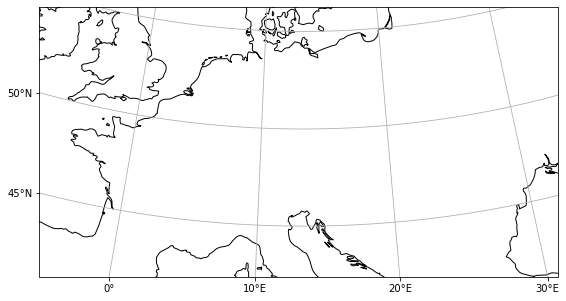

In [20]:
# Create a Lambert Conformal projection:
proj = ccrs.LambertConformal(central_longitude=13.3333, central_latitude=47.5,
                             false_easting=400000, false_northing=400000,
                             standard_parallels=(46, 49))

# Draw a set of axes with coastlines:
fig = plt.figure(figsize=(9, 9), frameon=True)
ax = fig.add_axes([0.08, 0.05, 0.8, 0.94], projection=proj)
ax.set_extent([-5, 31, 42, 55], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

# *must* call draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()

# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = [-110, -50, -40, -30, -20, -11, 0, 10, 20, 30, 40, 50]
yticks = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
ax.gridlines(xlocs=xticks, ylocs=yticks)

# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)
